# Cat Approach Detection Model Training

This notebook trains a model to detect if a cat is approaching. The model is built using TensorFlow/Keras and then evaluated for its performance.

See: https://www.tensorflow.org/tutorials/images/classification

In [17]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Physical Devices:", tf.config.list_physical_devices('GPU'))


from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())


TensorFlow version: 2.10.1
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['/device:CPU:0', '/device:GPU:0']


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load data

### checkout labels

In [4]:
os.getcwd()

'c:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\modelling'

In [5]:
# Load csv file
df = pd.read_csv('labels.csv', header=None)
print("csv file loaded. Number of rows:", len(df))
# Note: Pandas treats the first row as the header by default and does not count it as a data row. 
# Because the file does not contain a header, we will set header=None

# add header row: img, approach
df.columns = ['img', 'approach']

# check first 3 rows
print(df.head(3))


csv file loaded. Number of rows: 61582
                                           img approach
0  2023_12_21_00_07_25_953092_cat_detected.jpg        y
1  2023_12_21_00_07_28_754026_cat_detected.jpg        y
2  2023_12_21_00_07_29_471742_cat_detected.jpg        n


Checkout original labels

In [6]:
# count category numbers for approach = y and approach = n
print("Nr of images with cat approaching", len(df[df['approach'] == 'y']))
print("Nr of images without a cat approaching", len(df[df['approach'] == 'n']))
print("Nr of images to exclude", len(df[df['approach'] == 'x']))
print("Nr of images with prey", len(df[df['approach'] == 'p']))
print("Nr of images with error", len(df[df['approach'] == 'E']))
print("Nr of images total",  len(df[df['approach'] == 'E']) + len(df[df['approach'] == 'x']) + len(df[df['approach'] == 'p']) + len(df[df['approach'] == 'n']) + len(df[df['approach'] == 'y']))

Nr of images with cat approaching 19109
Nr of images without a cat approaching 42024
Nr of images to exclude 235
Nr of images with prey 212
Nr of images with error 2
Nr of images total 61582


Checkout labels after cleaning

In [7]:
# Exclude rows with 'x' in the 'approach' column
df = df[df['approach'] != 'x']

# Exclude rows with 'E' in the 'approach' column
df = df[df['approach'] != 'E']

# Rename 'p' to 'y' in the 'approach' column
df['approach'] = df['approach'].apply(lambda x: 'y' if x == 'p' else x)

# count category numbers for approach = y and approach = n
print("Nr of images with cat approaching", len(df[df['approach'] == 'y']))
print("Nr of images without a cat approaching", len(df[df['approach'] == 'n']))
print("Nr of images to exclude", len(df[df['approach'] == 'x']))
print("Nr of images with prey", len(df[df['approach'] == 'p']))
print("Nr of images with error", len(df[df['approach'] == 'E']))
print("Nr of images VALID",  len(df[df['approach'] == 'E']) + len(df[df['approach'] == 'x']) + len(df[df['approach'] == 'p']) + len(df[df['approach'] == 'n']) + len(df[df['approach'] == 'y']))

Nr of images with cat approaching 19321
Nr of images without a cat approaching 42024
Nr of images to exclude 0
Nr of images with prey 0
Nr of images with error 0
Nr of images VALID 61345


Images labelled with 'x' were testimages (i.e., images that were not taken in the real environment), thus excluded. Images labeled with E threw an error during labelling, thus excluded.
Images labelled with 'p' are already labelled as prey for later use. However, for now we only need the distinction between approach and no approach.

### Checkout images

In [11]:
# Define the path to the "cats_training" folder
image_folder = 'Y:\cats_approach_training_2024_05_19'
print("Image folder:", image_folder)

Image folder: Y:\cats_approach_training_2024_05_19


In [12]:
# count number of items in the folder
print("Number of items in the folder:", len(os.listdir(image_folder)))
# Note: This counts also the hidden file called Thumbs.db (it's hidden even if showing hidden files)

Number of items in the folder: 61583


Displaying 2023_12_21_00_07_28_754026_cat_detected.jpg:


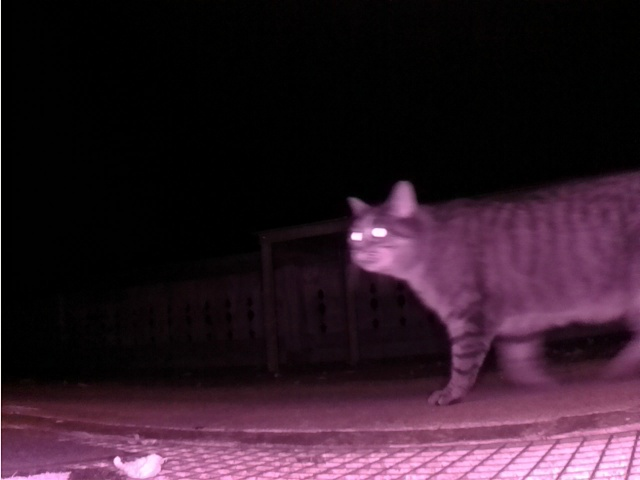

Displaying 2023_12_21_01_00_56_143100_cat_detected.jpg:


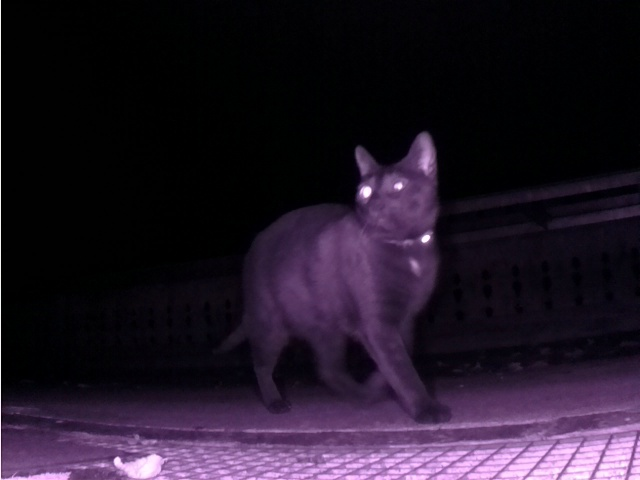

Displaying 2023_12_21_06_50_26_129435_cat_detected.jpg:


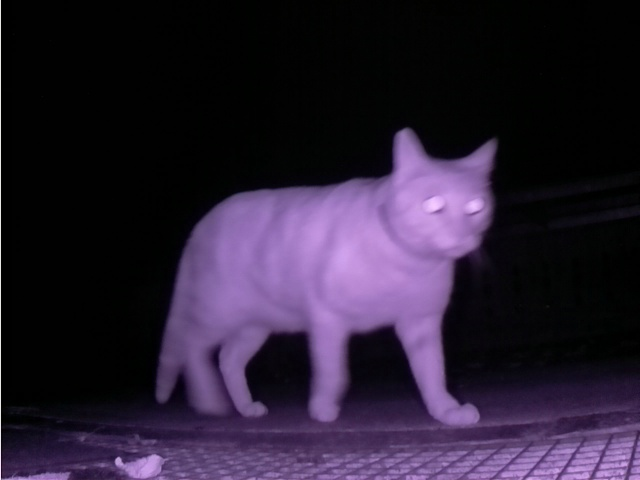

In [29]:
# Iterate through the .jpg files in the folder and display each image
examples_folder = '../examples'

for filename in os.listdir(examples_folder):
    if filename.lower().endswith('.jpg'):
        # Open the image file
        with Image.open(os.path.join(examples_folder, filename)) as img:
            # Display the image
            print(f"Displaying {filename}:")
            display(img)

In [31]:
# Iterate through the .jpg files in the folder and display properties
for filename in os.listdir(examples_folder):
    if filename.lower().endswith('.jpg'):
        # Path to the image file
        file_path = os.path.join(examples_folder, filename)
        
        # Open the image file
        with Image.open(file_path) as img:
            # Display the image properties
            file_size = os.path.getsize(file_path)  # File size in bytes
            dimensions = img.size  # Dimensions of the image (width x height)
            mode = img.mode  # Image mode (e.g., RGB, L)
            channels = img.getbands()  # Gets the channels (e.g., ('R', 'G', 'B') for RGB)
            
            print(f"Filename: {filename}")
            print(f"  File Size: {file_size} bytes")
            print(f"  Dimensions: {dimensions} (width x height pixels)")
            print(f"  Mode: {mode}")
            print(f"  Channels: {channels}")
            print()

Filename: 2023_12_21_00_07_28_754026_cat_detected.jpg
  File Size: 54446 bytes
  Dimensions: (640, 480) (width x height pixels)
  Mode: RGB
  Channels: ('R', 'G', 'B')

Filename: 2023_12_21_01_00_56_143100_cat_detected.jpg
  File Size: 54478 bytes
  Dimensions: (640, 480) (width x height pixels)
  Mode: RGB
  Channels: ('R', 'G', 'B')

Filename: 2023_12_21_06_50_26_129435_cat_detected.jpg
  File Size: 44718 bytes
  Dimensions: (640, 480) (width x height pixels)
  Mode: RGB
  Channels: ('R', 'G', 'B')



## Preprocessing data

In [37]:
# print working directory
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\mirela\Documents\gitRepos\CatWatcher\modelling


In [40]:
# Define the path to the "cats_training" folder
image_folder = 'Y:\cats_approach_training_2024_05_19'
print("Image folder:", image_folder)

# Preprocess images
def preprocess_image(file_name):
    img_path = os.path.join(image_folder, file_name)
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Unable to read the image file {img_path}. Check file path and integrity.")
    img = cv2.resize(img, (64, 64))  # Resize to uniform size
    img = img / 255.0  # Normalize pixel values
    return img

# Update 'img' column with full paths
df['img'] = df['img'].apply(preprocess_image)
print("Image preprocessing complete.")

# Before splitting data
print("Preparing labels...")
df['approach'] = df['approach'].apply(lambda x: 1 if x == 'y' else 0)

Image folder: Y:\cats_approach_training_2024_05_19


KeyboardInterrupt: 

In [ ]:
# check first 3 rows
print(df.head(3))

### Prepare Training, Validation, and Test Datasets

In [9]:
# Split data into training and temporary data (combining validation and test)
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)

# Split the temporary data into validation and test data
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Data split into training, validation, and test sets.")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Data split into training, validation, and test sets.
Training set size: 20429
Validation set size: 6810
Test set size: 6810


## Create simple model

### Train model

In [16]:
# Create a simple CNN model
with tf.device('/GPU:0'):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Specify a lower learning rate
    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print("Model created and compiled.")

# Convert dataframes to numpy arrays for training and validation sets
X_train = np.array(list(train_df['img']))
y_train = np.array(list(train_df['approach']))
X_val = np.array(list(val_df['img']))
y_val = np.array(list(val_df['approach']))

# Train the model
print("Starting model training...")
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
print("Model training complete.")

Model created and compiled.
Starting model training...
Epoch 1/10
639/639 [==============================] - 2s 3ms/step - loss: 0.3185 - accuracy: 0.8559 - val_loss: 0.2877 - val_accuracy: 0.8828
Epoch 2/10
639/639 [==============================] - 2s 3ms/step - loss: 0.2015 - accuracy: 0.9165 - val_loss: 0.1954 - val_accuracy: 0.9184
Epoch 3/10
639/639 [==============================] - 2s 3ms/step - loss: 0.1479 - accuracy: 0.9415 - val_loss: 0.1663 - val_accuracy: 0.9314
Epoch 4/10
639/639 [==============================] - 2s 3ms/step - loss: 0.1127 - accuracy: 0.9553 - val_loss: 0.1716 - val_accuracy: 0.9344
Epoch 5/10
639/639 [==============================] - 2s 3ms/step - loss: 0.0897 - accuracy: 0.9673 - val_loss: 0.1668 - val_accuracy: 0.9401
Epoch 6/10
639/639 [==============================] - 2s 3ms/step - loss: 0.0698 - accuracy: 0.9748 - val_loss: 0.1523 - val_accuracy: 0.9483
Epoch 7/10
639/639 [==============================] - 2s 3ms/step - loss: 0.0547 - accuracy: 

### Plot

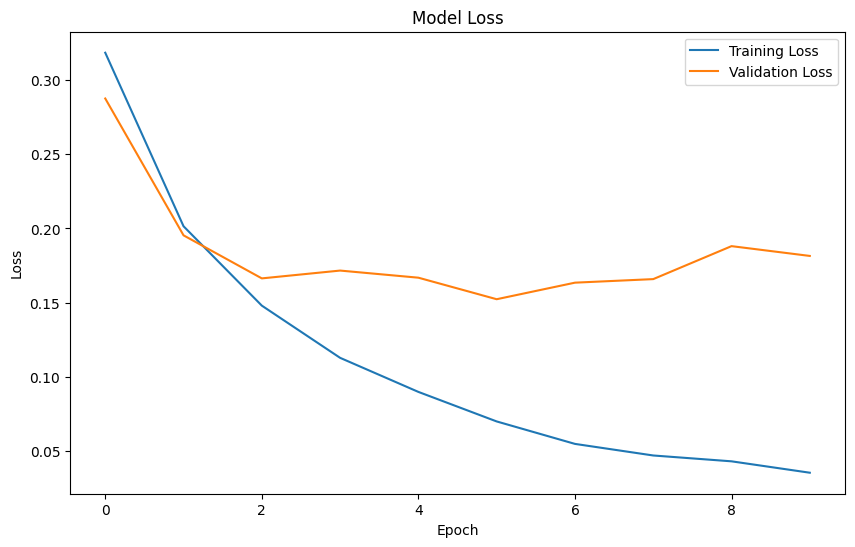

In [17]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

### Evaluate Model

In [17]:
# Model evaluation on test set
# Convert test dataframe to numpy arrays
X_test = np.array(list(test_df['img']))
y_test = np.array(list(test_df['approach']))

# Evaluate the model on the test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test set
predictions = model.predict(X_test)
predictions = np.round(predictions).astype(int).flatten()  # Convert probabilities to class labels

# Generate a classification report
report = classification_report(y_test, predictions, target_names=['No Cat approach', 'Cat approach'])
print(report)

Evaluating model on test set...
213/213 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 0.9521
Test Loss: 0.22004173696041107
Test Accuracy: 0.9521292448043823
213/213 [==============================] - 0s 1ms/step
                 precision    recall  f1-score   support

No Cat approach       0.97      0.96      0.96      4353
   Cat approach       0.92      0.95      0.93      2457

       accuracy                           0.95      6810
      macro avg       0.95      0.95      0.95      6810
   weighted avg       0.95      0.95      0.95      6810



#### Interpreting the results
* Precision: Out of all the images the model predicted to be positive, what fraction were actually positive? High precision indicates a low false positive rate.
* Recall (Sensitivity): Out of all the positive images, what fraction were correctly predicted as positive? High recall indicates a low false negative rate.
* F1 score: Weighted average of precision and recall

In [2]:
# Save the model
model.save('cat_approach_detector_model.h5')  # Saves as an HDF5 file

## Improve Model

### Reduce overfitting

In [19]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Specify a lower learning rate
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print("Model created and compiled.")

# Convert dataframes to numpy arrays for training and validation sets
X_train = np.array(list(train_df['img']))
y_train = np.array(list(train_df['approach']))
X_val = np.array(list(val_df['img']))
y_val = np.array(list(val_df['approach']))

# Train the model
print("Starting model training...")
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
print("Model training complete.")

Model created and compiled.
Starting model training...
Epoch 1/50
639/639 [==============================] - 2s 3ms/step - loss: 0.4335 - accuracy: 0.7838 - val_loss: 0.3924 - val_accuracy: 0.8332
Epoch 2/50
639/639 [==============================] - 2s 3ms/step - loss: 0.3377 - accuracy: 0.8479 - val_loss: 0.3601 - val_accuracy: 0.8562
Epoch 3/50
639/639 [==============================] - 2s 3ms/step - loss: 0.3026 - accuracy: 0.8658 - val_loss: 0.3031 - val_accuracy: 0.8806
Epoch 4/50
639/639 [==============================] - 2s 3ms/step - loss: 0.2789 - accuracy: 0.8787 - val_loss: 0.3067 - val_accuracy: 0.8725
Epoch 5/50
639/639 [==============================] - 2s 3ms/step - loss: 0.2622 - accuracy: 0.8889 - val_loss: 0.2859 - val_accuracy: 0.8922
Epoch 6/50
639/639 [==============================] - 2s 3ms/step - loss: 0.2449 - accuracy: 0.8986 - val_loss: 0.2809 - val_accuracy: 0.8869
Epoch 7/50
639/639 [==============================] - 2s 3ms/step - loss: 0.2273 - accuracy: 

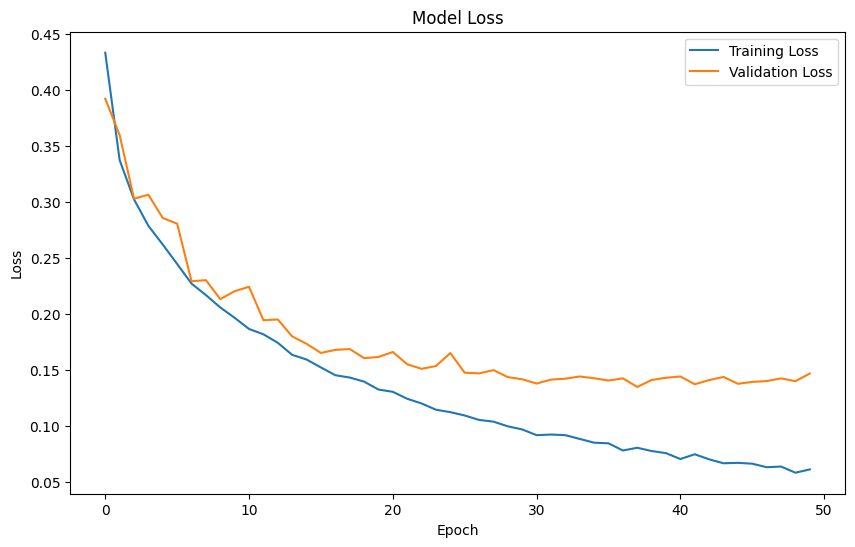

In [20]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Add layers

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# Specify a lower learning rate
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print("Model created and compiled.")

# Convert dataframes to numpy arrays for training and validation sets
X_train = np.array(list(train_df['img']))
y_train = np.array(list(train_df['approach']))
X_val = np.array(list(val_df['img']))
y_val = np.array(list(val_df['approach']))

# Train the model
print("Starting model training...")
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
print("Model training complete.")

# New

Image folder: c:\Users\mirela\Documents\gitRepos\CatDetector\CatApproach\cats_approach_training_2024_04_30
Epoch 1/100
639/639 [==============================] - 6s 5ms/step - loss: 0.6264 - accuracy: 0.7221 - val_loss: 0.6397 - val_accuracy: 0.6505 - lr: 1.0000e-04
Epoch 2/100
639/639 [==============================] - 3s 5ms/step - loss: 0.4697 - accuracy: 0.7891 - val_loss: 0.5459 - val_accuracy: 0.7213 - lr: 1.0000e-04
Epoch 3/100
639/639 [==============================] - 3s 5ms/step - loss: 0.4151 - accuracy: 0.8140 - val_loss: 0.4661 - val_accuracy: 0.7693 - lr: 1.0000e-04
Epoch 4/100
639/639 [==============================] - 3s 5ms/step - loss: 0.3765 - accuracy: 0.8348 - val_loss: 0.3708 - val_accuracy: 0.8294 - lr: 1.0000e-04
Epoch 5/100
639/639 [==============================] - 3s 5ms/step - loss: 0.3461 - accuracy: 0.8463 - val_loss: 0.3581 - val_accuracy: 0.8421 - lr: 1.0000e-04
Epoch 6/100
639/639 [==============================] - 3s 5ms/step - loss: 0.3265 - accuracy:

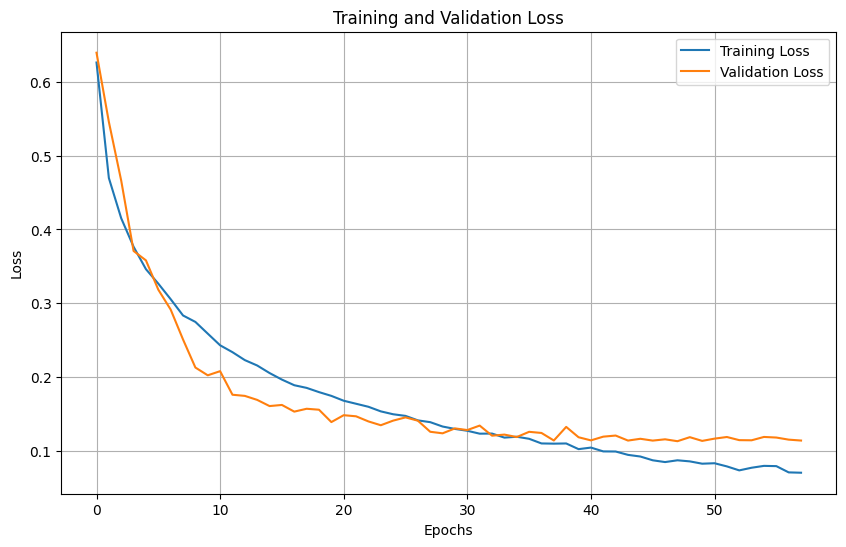

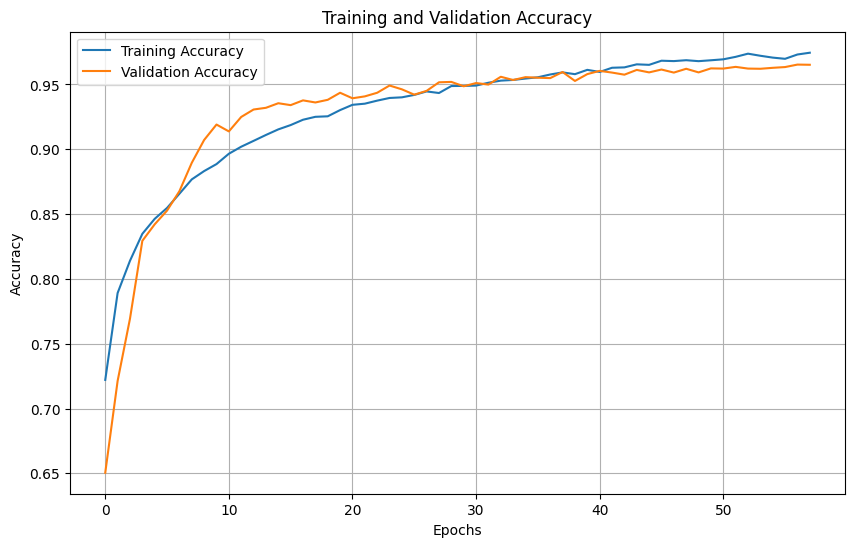

213/213 [==============================] - 0s 2ms/step - loss: 0.1203 - accuracy: 0.9601
Test Loss: 0.12030495703220367
Test Accuracy: 0.9600587487220764
213/213 [==============================] - 0s 1ms/step
                 precision    recall  f1-score   support

No Cat approach       0.97      0.97      0.97      4353
   Cat approach       0.94      0.95      0.94      2457

       accuracy                           0.96      6810
      macro avg       0.96      0.96      0.96      6810
   weighted avg       0.96      0.96      0.96      6810



In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf

# Define the path to the "cats_training" folder
image_folder = os.path.join(os.getcwd(), 'cats_approach_training_2024_04_30')
print("Image folder:", image_folder)

# Check for GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Preprocess images
def preprocess_image(file_name):
    img_path = os.path.join(image_folder, file_name)
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Unable to read the image file {img_path}. Check file path and integrity.")
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    return img

# Load and preprocess data
df = pd.read_csv('labels_approach.csv')
df.columns = ['img', 'approach']
df = df[df['approach'] != 'x']
df['approach'] = df['approach'].apply(lambda x: 'y' if x == 'p' else x)
df['img'] = df['img'].apply(preprocess_image)
df['approach'] = df['approach'].apply(lambda x: 1 if x == 'y' else 0)

# Split data into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert dataframes to numpy arrays
X_train = np.array(list(train_df['img']))
y_train = np.array(list(train_df['approach']))
X_val = np.array(list(val_df['img']))
y_val = np.array(list(val_df['approach']))
X_test = np.array(list(test_df['img']))
y_test = np.array(list(test_df['approach']))

# Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test set
predictions = model.predict(X_test)
predictions = np.round(predictions).astype(int).flatten()

# Generate a classification report
report = classification_report(y_test, predictions, target_names=['No Cat approach', 'Cat approach'])
print(report)

